In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [14]:

data = pd.read_csv('../data/local_ex/astapm/asrs.csv', low_memory=False)
narrative_data = pd.read_csv('../data/local_ex/astapm/asrs_narrative.csv', low_memory=False)
safety_factors_data = pd.read_csv('../data/local_ex/astapm/asrs_safety_factors.csv', low_memory=False)

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
import numpy as np

import pandas as pd
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict

class DataPreprocessor:
    def __init__(self, technique='NMF', n_components=5):
        self.technique = technique
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.feature_engineer = None
    
    def preprocess(self, data: pd.DataFrame):

        data['narrative'] = data['narrative_01'] + data['narrative_02']

        data['narrative'] = [entry.lower() for entry in data['narrative']]

        # Handle missing values
        data.fillna(method='ffill', inplace=True)
        
        # Standardize features
        scaled_data = self.scaler.fit_transform(data)
        
        # Feature engineering based on the selected technique
        if self.technique == 'NMF':
            self.feature_engineer = NMF(n_components=self.n_components)
            transformed_data = self.feature_engineer.fit_transform(scaled_data)
        else:
            raise ValueError(f"Unsupported feature engineering technique: {self.technique}")
        
        return transformed_data

    def clean_and_tokenize_narratives(self, data: pd.DataFrame):

        # Step - a : Remove blank rows if any in the 'narrative' columns.
        data['narrative'] = data['narrative_01'] + ' ' + data['narrative_02']
        data.dropna(subset=['narrative'], inplace=True)

        # Step - b : Change all the text to lower case.
        data['narrative'] = data['narrative'].str.lower()

        # Step - c : Tokenization : In this each entry in the corpus will be broken into a set of words
        data['narrative'] = data['narrative'].apply(word_tokenize)

        # Step - d : Remove Stop words, Non-Numeric and perform Word Stemming/Lemmatizing
        # Initialize the tag map for lemmatization
        tag_map = defaultdict(lambda: wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV

        # Initialize WordNetLemmatizer
        word_Lemmatized = WordNetLemmatizer()

        # Function to process text
        def process_text(entry):
            final_words = []
            for word, tag in pos_tag(entry):
                if word not in stopwords.words('english') and word.isalpha():
                    word_final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
                    final_words.append(word_final)
            return final_words

        # Apply the text processing to each entry in 'narrative'
        data['narrative_pre_processed'] = data['narrative'].apply(process_text)

        # Optional: Convert the list of words back to a string (if needed)
        data['narrative_pre_processed'] = data['narrative_pre_processed'].apply(lambda x: ' '.join(x))

        return data
    
dataPreprocessor = DataPreprocessor()

# https://neptune.ai/blog/text-classification-tips-and-tricks-kaggle-competitions

In [26]:
data_df = pd.merge(data, narrative_data, on='acn', how='left')
data_df = pd.merge(data_df, safety_factors_data, on='acn', how='left')

# data = data[data['year'] == 2023]
data_df.head()

,acn,date,year,month,from_time,to_time,narrative_01,narrative_02,aircraft_component,aircraft_component_problem,environment_flight_conditions,environment_weather_elements_visibility,environment_light,contributing_factors,primary_problem,human_factors
0,1811483,2021-06-01,2021,6,12:01,18:00,We were cleared for the Visual Approach. The F...,NaN,NaN,NaN,VMC,NaN,Daylight,Procedure; Software and Automation; Human Factors,Human Factors,Situational Awareness; Workload; Time Pressure
1,1811535,2021-05-01,2021,5,18:01,24:00,Received a Level 1 'Emerg Power On' message wh...,During cruise at FL380 we received a level one...,Electrical Distribution,Malfunctioning,VMC,NaN,Night,Aircraft,Aircraft,NaN
2,1811548,2021-06-01,2021,6,06:01,12:00,I was [the] pilot flying; headed into ZZZ. It ...,I was the First Officer and the Pilot Monitori...,NaN,NaN,NaN,Clear,NaN,Human Factors,Human Factors,Human-Machine Interface
3,1811550,2021-06-01,2021,6,06:01,12:00,After starting engines and running applicable ...,NaN,Normal Brake System,Malfunctioning,VMC,NaN,Daylight,Aircraft,Aircraft,NaN
4,1811597,2021-06-01,2021,6,06:01,12:00,I was conducting an intro flight in Aircraft X...,NaN,Reciprocating Engine Assembly,Malfunctioning,VMC,10,Daylight,Aircraft,Aircraft,NaN


In [27]:
processed_data = dataPreprocessor.clean_and_tokenize_narratives(data_df)

In [28]:
processed_data.head()

,acn,date,year,month,from_time,to_time,narrative_01,narrative_02,aircraft_component,aircraft_component_problem,environment_flight_conditions,environment_weather_elements_visibility,environment_light,contributing_factors,primary_problem,human_factors,narrative,narrative_pre_processed
1,1811535,2021-05-01,2021,5,18:01,24:00,Received a Level 1 'Emerg Power On' message wh...,During cruise at FL380 we received a level one...,Electrical Distribution,Malfunctioning,VMC,NaN,Night,Aircraft,Aircraft,NaN,"[received, a, level, 1, 'emerg, power, on, ', ...",receive level power message cruise reference q...
2,1811548,2021-06-01,2021,6,06:01,12:00,I was [the] pilot flying; headed into ZZZ. It ...,I was the First Officer and the Pilot Monitori...,NaN,NaN,NaN,Clear,NaN,Human Factors,Human Factors,Human-Machine Interface,"[i, was, [, the, ], pilot, flying, ;, headed, ...",pilot fly head zzz vmc severe clear afternoon ...
9,1811697,2021-06-01,2021,6,NaN,NaN,Aircraft was dispatched with an inoperative Pa...,Approximately 240 nm from ZZZ; at a cruise alt...,Air Cycle Machine,Failed; Malfunctioning,NaN,NaN,NaN,MEL; Aircraft,Aircraft,Time Pressure; Troubleshooting,"[aircraft, was, dispatched, with, an, inoperat...",aircraft dispatch inoperative pack due regulat...
13,1811820,2021-06-01,2021,6,12:01,18:00,During arrival into ZZZ we received 4 runway c...,After a rushed departure due to company operat...,NaN,NaN,VMC,NaN,Daylight,Aircraft; Human Factors,Human Factors,Workload; Troubleshooting,"[during, arrival, into, zzz, we, received, 4, ...",arrival zzz receive runway change minute time ...
14,1811826,2021-06-01,2021,6,18:01,24:00,The incident happened during our descent on th...,During our descent on ZZZZZ arrival into ZZZ; ...,NaN,NaN,VMC,NaN,Dusk,Human Factors,Human Factors,Communication Breakdown,"[the, incident, happened, during, our, descent...",incident happen descent zzzzz arrival zzz far ...


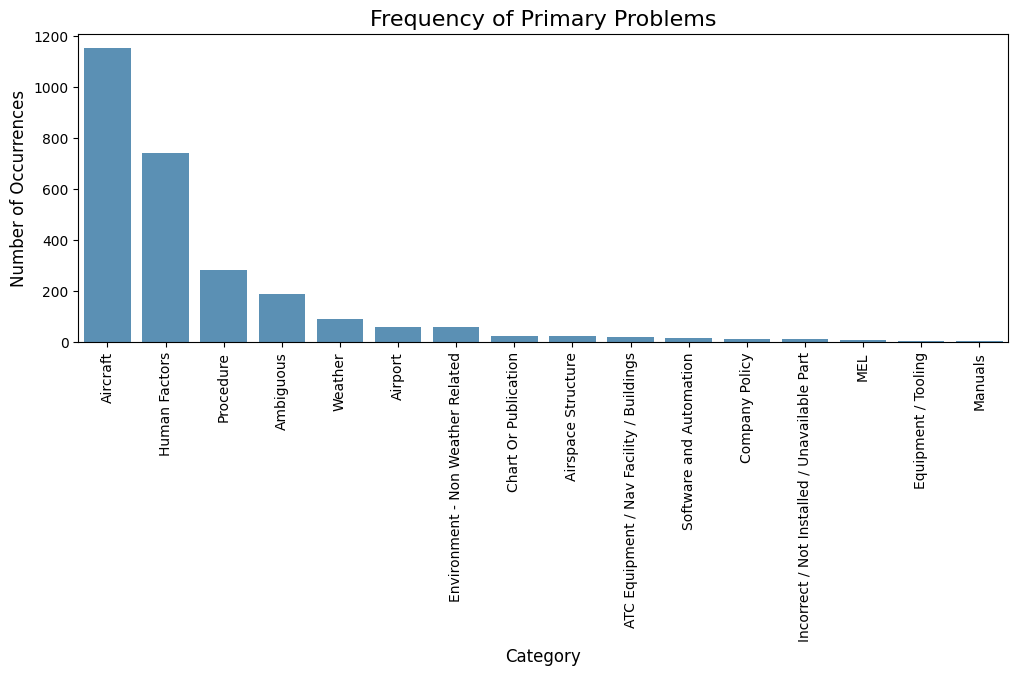

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'processed_data' is your DataFrame and 'primary_problem' is a column in it.
cnt_pro = processed_data['primary_problem'].value_counts()

plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.title('Frequency of Primary Problems', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [30]:
# Label encoding for 'primary_problem'
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(processed_data['primary_problem'])
processed_data['primary_problem_encode'] = y

processed_data.head()

,acn,date,year,month,from_time,to_time,narrative_01,narrative_02,aircraft_component,aircraft_component_problem,environment_flight_conditions,environment_weather_elements_visibility,environment_light,contributing_factors,primary_problem,human_factors,narrative,narrative_pre_processed,primary_problem_encode
1,1811535,2021-05-01,2021,5,18:01,24:00,Received a Level 1 'Emerg Power On' message wh...,During cruise at FL380 we received a level one...,Electrical Distribution,Malfunctioning,VMC,NaN,Night,Aircraft,Aircraft,NaN,"[received, a, level, 1, 'emerg, power, on, ', ...",receive level power message cruise reference q...,1
2,1811548,2021-06-01,2021,6,06:01,12:00,I was [the] pilot flying; headed into ZZZ. It ...,I was the First Officer and the Pilot Monitori...,NaN,NaN,NaN,Clear,NaN,Human Factors,Human Factors,Human-Machine Interface,"[i, was, [, the, ], pilot, flying, ;, headed, ...",pilot fly head zzz vmc severe clear afternoon ...,9
9,1811697,2021-06-01,2021,6,NaN,NaN,Aircraft was dispatched with an inoperative Pa...,Approximately 240 nm from ZZZ; at a cruise alt...,Air Cycle Machine,Failed; Malfunctioning,NaN,NaN,NaN,MEL; Aircraft,Aircraft,Time Pressure; Troubleshooting,"[aircraft, was, dispatched, with, an, inoperat...",aircraft dispatch inoperative pack due regulat...,1
13,1811820,2021-06-01,2021,6,12:01,18:00,During arrival into ZZZ we received 4 runway c...,After a rushed departure due to company operat...,NaN,NaN,VMC,NaN,Daylight,Aircraft; Human Factors,Human Factors,Workload; Troubleshooting,"[during, arrival, into, zzz, we, received, 4, ...",arrival zzz receive runway change minute time ...,9
14,1811826,2021-06-01,2021,6,18:01,24:00,The incident happened during our descent on th...,During our descent on ZZZZZ arrival into ZZZ; ...,NaN,NaN,VMC,NaN,Dusk,Human Factors,Human Factors,Communication Breakdown,"[the, incident, happened, during, our, descent...",incident happen descent zzzzz arrival zzz far ...,9


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect = TfidfVectorizer(stop_words='english', max_features=5000)
Tfidf_vect.fit(processed_data['narrative_pre_processed'])
X_tfidf = Tfidf_vect.transform(processed_data['narrative_pre_processed'])

In [61]:
Tfidf_vect.vocabulary_
print(X_tfidf)

  (0, 101)	0.0734409653930843
  (0, 146)	0.03945435192110761
  (0, 217)	0.08170774117266093
  (0, 246)	0.04746291707251095
  (0, 249)	0.07556703144914359
  (0, 317)	0.026678955218392378
  (0, 419)	0.03279560263758933
  (0, 509)	0.07733175491713608
  (0, 516)	0.038389133614094656
  (0, 577)	0.07054319763765073
  (0, 599)	0.04928706186043715
  (0, 679)	0.06390888918654955
  (0, 702)	0.07471770825127887
  (0, 720)	0.025158187395335298
  (0, 779)	0.03022714264417396
  (0, 807)	0.0641990889434409
  (0, 837)	0.0718115310154353
  (0, 845)	0.039219727394217675
  (0, 858)	0.04960889023542862
  (0, 861)	0.040346997734026085
  (0, 914)	0.025375272262389646
  (0, 1092)	0.04706779905033981
  (0, 1143)	0.0717753245828614
  (0, 1186)	0.0739374762773934
  (0, 1250)	0.05247468733452097
  :	:
  (948, 3744)	0.06015376386718396
  (948, 3777)	0.15208513523844785
  (948, 3868)	0.04195542962520984
  (948, 4020)	0.13809742101238046
  (948, 4023)	0.13028069268589312
  (948, 4031)	0.037279440013124
  (948, 4048

In [32]:
from sklearn import model_selection, naive_bayes, svm

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X_tfidf, y ,test_size=0.3)

In [33]:
arr = label_encoder.inverse_transform(Train_Y)
count = np.count_nonzero(arr == 'Human Factors')
count, arr.size

(531, 1876)

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)
# Train_X_Tfidf_resampled, Train_Y_resampled = smote.fit_resample(Train_X_Tfidf, Train_Y)


SVM = svm.SVC(C=1.0, kernel='linear', degree=3, class_weight='balanced', gamma='auto', probability=True)
SVM.fit(Train_X,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  62.810945273631845


In [35]:
predictions_SVM_all = SVM.predict(X_tfidf)

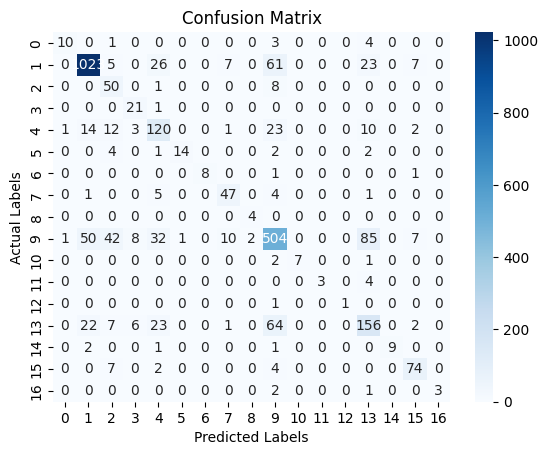

2680

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Plot the confusion matrix
# plt.figure(figsize=(10, 7))

# Compute the confusion matrix
cm = confusion_matrix(y, predictions_SVM_all)

# raw_classes = label_encoder.inverse_transform(SVM.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=SVM.classes_, yticklabels=SVM.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

predictions_SVM_all.size
# raw_classes

In [37]:
processed_data['predicted_label'] = predictions_SVM_all
processed_data[processed_data['primary_problem'] == 'Human Factors'].head()

,acn,date,year,month,from_time,to_time,narrative_01,narrative_02,aircraft_component,aircraft_component_problem,environment_flight_conditions,environment_weather_elements_visibility,environment_light,contributing_factors,primary_problem,human_factors,narrative,narrative_pre_processed,primary_problem_encode,predicted_label
2,1811548,2021-06-01,2021,6,06:01,12:00,I was [the] pilot flying; headed into ZZZ. It ...,I was the First Officer and the Pilot Monitori...,NaN,NaN,NaN,Clear,NaN,Human Factors,Human Factors,Human-Machine Interface,"[i, was, [, the, ], pilot, flying, ;, headed, ...",pilot fly head zzz vmc severe clear afternoon ...,9,9
13,1811820,2021-06-01,2021,6,12:01,18:00,During arrival into ZZZ we received 4 runway c...,After a rushed departure due to company operat...,NaN,NaN,VMC,NaN,Daylight,Aircraft; Human Factors,Human Factors,Workload; Troubleshooting,"[during, arrival, into, zzz, we, received, 4, ...",arrival zzz receive runway change minute time ...,9,9
14,1811826,2021-06-01,2021,6,18:01,24:00,The incident happened during our descent on th...,During our descent on ZZZZZ arrival into ZZZ; ...,NaN,NaN,VMC,NaN,Dusk,Human Factors,Human Factors,Communication Breakdown,"[the, incident, happened, during, our, descent...",incident happen descent zzzzz arrival zzz far ...,9,9
15,1811827,2021-06-01,2021,6,12:01,18:00,During the pre-start check; the crew confirmed...,Climbing out we were assigned to maintain 16;0...,NaN,NaN,VMC,NaN,Daylight,Human Factors,Human Factors,Situational Awareness; Human-Machine Interface...,"[during, the, pre-start, check, ;, the, crew, ...",check crew confirm three altimeter set properl...,9,9
24,1812051,2021-06-01,2021,6,06:01,12:00,On arrival into EDF we were on ANC Approach. A...,As International Relief Officer; I heard ATC i...,NaN,NaN,VMC,NaN,Daylight,Human Factors,Human Factors,Communication Breakdown,"[on, arrival, into, edf, we, were, on, anc, ap...",arrival edf anc approach initial contact anc a...,9,9


(949, 12)

# Stopword Removal

In [22]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
print(stopwords.words('english'))

# Stopword Removal
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

# # Term Extraction
def extract_terms(text, min_length=2, max_length=200):
    terms = re.findall(r'\b\w{%d,%d}\b' % (min_length, max_length), text)
    return ' '.join(terms)

def filter_terms(matrix, min_docs=2, max_docs=8192):
    term_frequencies = np.asarray(matrix.sum(axis=0)).flatten()
    terms_to_keep = np.where((term_frequencies >= min_docs) & (term_frequencies <= max_docs))[0]
    return matrix[:, terms_to_keep]


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [24]:
data['narrative'] = data['narrative'].apply(remove_stopwords)
data['synopsis'] = data['synopsis'].apply(remove_stopwords)

data['narrative'] = data['narrative'].apply(extract_terms)
data['synopsis'] = data['synopsis'].apply(extract_terms)

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix_narrative = tfidf_vectorizer.fit_transform(data['narrative'])
# tfidf_matrix_synopsis = tfidf_vectorizer.fit_transform(data['synopsis'])

# vectorizer = CountVectorizer()
# bow_matrix_narrative = vectorizer.fit_transform(data['narrative'])
# bow_matrix_synopsis = vectorizer.fit_transform(data['synopsis'])

# filtered_bow_matrix_narrative = filter_terms(bow_matrix_narrative)
# filtered_bow_matrix_synopsis = filter_terms(bow_matrix_synopsis)

# normalized_matrix_narrative = normalize(filtered_bow_matrix_narrative, norm='l2')
# normalized_matrix_synopsis = normalize(filtered_bow_matrix_synopsis, norm='l2')

In [25]:
# Limitation: Sample a subset of the data for faster training
data_sample = data.sample(frac=0.01, random_state=42).copy()

In [26]:
# Combine Narrative and Synopsis for feature extraction
data_sample['combined_text'] = data_sample['narrative'] + ' ' + data_sample['synopsis']

# TF-IDF weighting
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_sample['combined_text'])

# Normalize
normalized_matrix = normalize(tfidf_matrix, norm='l2')

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

def svc_train(y):

    # Assume 'human_factors_labels' is your target variable for human factors classification
    X_train, X_test, y_train, y_test = train_test_split(normalized_matrix, y, test_size=0.25, random_state=42)

    classifier_human_factors = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced'))
    classifier_human_factors.fit(X_train, y_train)

    # Evaluate performance
    y_pred_human_factors = classifier_human_factors.predict(X_test)
    print(classification_report(y_test, y_pred_human_factors))

    return classifier_human_factors

# human_factors_pred
# title = 'Human Factors Trend Over Time'
def display_pred(col, title):

    # # Group by year_month and count occurrences
    data_sample['date_time___'] = pd.to_datetime(data_sample['date_time'], format='%Y-%m-%d', errors='coerce')
    data_sample['year_month'] = data_sample['date_time___'].dt.to_period('M')

    factors_trend = data_sample.groupby('year_month')[col].value_counts().unstack().fillna(0)

    # Plot trends
    factors_trend.plot(figsize=(15, 7), title=title)
    plt.show()
    factors_trend


## human_factors_pred

In [28]:
classifier_human_factors = svc_train(data_sample['human_factors_1'])
data_sample['human_factors_pred'] = classifier_human_factors.predict(normalized_matrix)

/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_module

                          precision    recall  f1-score   support

 Communication Breakdown       0.30      0.35      0.32        34
               Confusion       0.00      0.00      0.00        14
             Distraction       0.00      0.00      0.00         4
                 Fatigue       0.00      0.00      0.00         1
 Human-Machine Interface       0.00      0.00      0.00        11
         Other / Unknown       0.00      0.00      0.00         6
   Physiological - Other       0.00      0.00      0.00         3
   Situational Awareness       0.25      0.61      0.36        36
           Time Pressure       0.00      0.00      0.00         8
Training / Qualification       0.00      0.00      0.00         3
         Troubleshooting       0.00      0.00      0.00        11
                Workload       0.00      0.00      0.00         9
              _UNDEFINED       0.42      0.50      0.45        44

                accuracy                           0.30       184
        

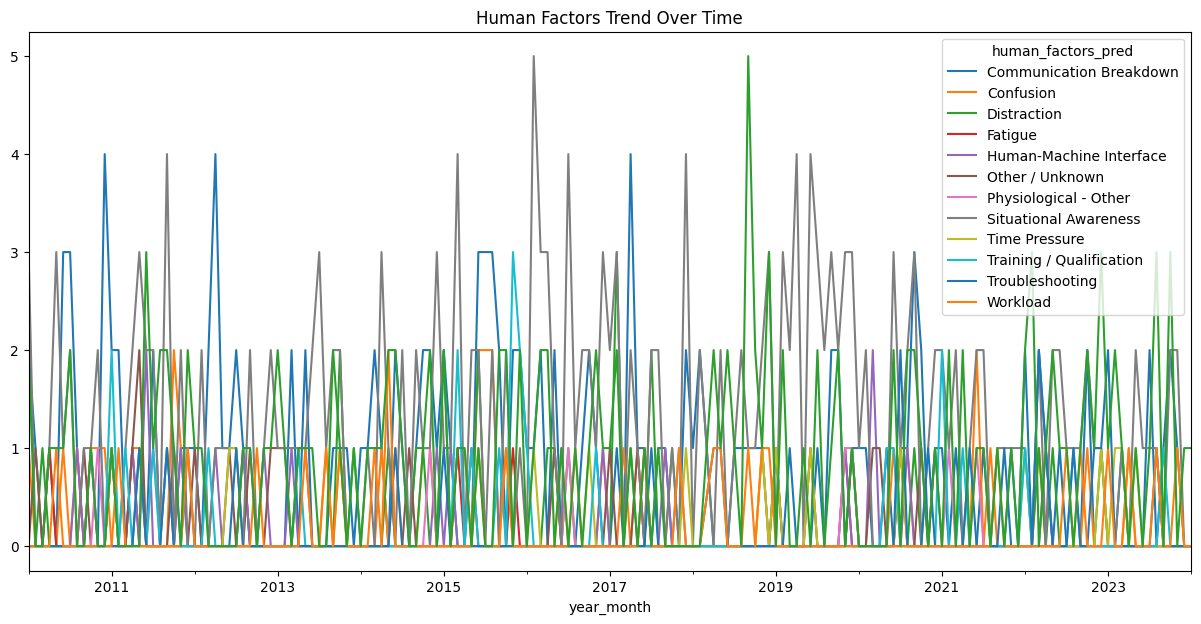

In [15]:
display_pred('human_factors_pred', 'Human Factors Trend Over Time')

## primary_problem

In [16]:
data_sample['primary_problem'] = data_sample['primary_problem'].fillna('UNDEFINED')
classifier_human_factors = svc_train(data_sample['primary_problem'])
data_sample['primary_problem_pred'] = classifier_human_factors.predict(normalized_matrix)


/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_module

                                              precision    recall  f1-score   support

    ATC Equipment / Nav Facility / Buildings       0.00      0.00      0.00         3
                                    Aircraft       0.65      0.91      0.75        44
                                     Airport       0.00      0.00      0.00         3
                          Airspace Structure       0.00      0.00      0.00         2
                                   Ambiguous       0.67      0.10      0.17        20
                        Chart Or Publication       0.00      0.00      0.00         1
                              Company Policy       0.00      0.00      0.00         6
           Environment - Non Weather Related       0.00      0.00      0.00         8
                               Human Factors       0.42      0.86      0.57        56
Incorrect / Not Installed / Unavailable Part       0.00      0.00      0.00         1
                                         MEL       0.

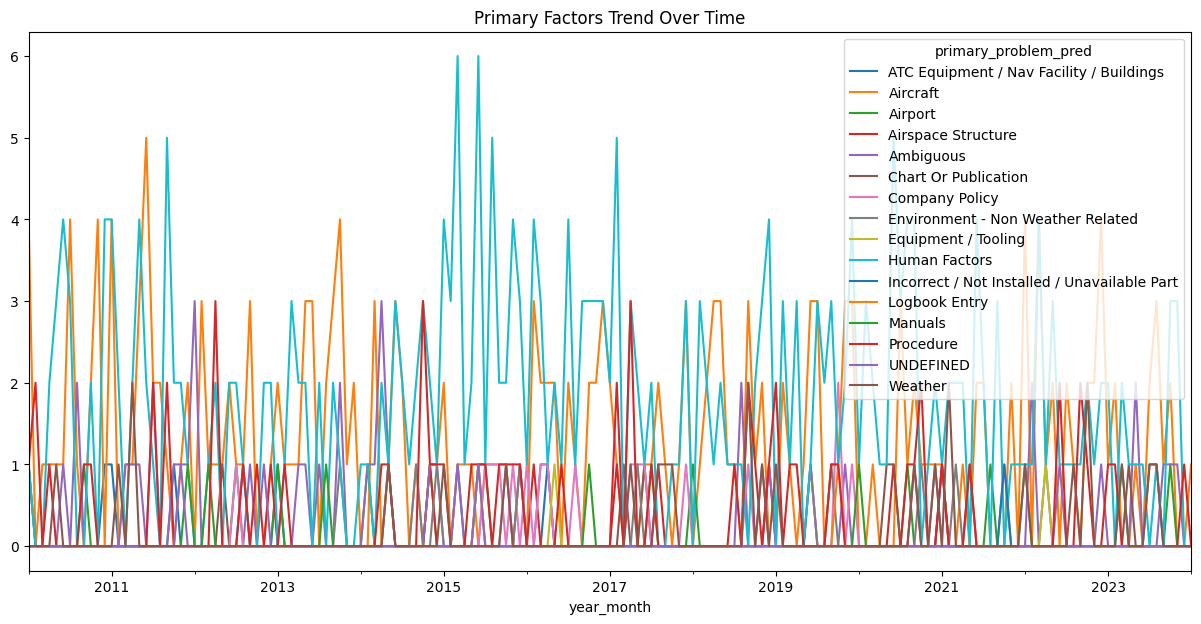

In [17]:
display_pred('primary_problem_pred', 'Primary Factors Trend Over Time')

In [3]:
data

,acn,year,month,date_time,state_reference,anomaly_main,primary_problem,human_factors,narrative,synopsis
0,866849,2010,1,2010-01-01,TX,ATC Issues,Human Factors,Workload; Confusion; Communication Breakdown,Ocean West and Offshore West/Central were comb...,ZHU Controllers reported that poorly coordinat...
1,866859,2010,1,2010-01-01,IL,ATC Issues,Human Factors,Communication Breakdown; Confusion; Human-Mach...,Aircraft X had a flight plan in URET (user req...,ZAU Controller reported an aircraft had a diff...
2,866866,2010,1,2010-01-01,TX,ATC Issues,Human Factors,Situational Awareness; Communication Breakdown...,I was working D-79 when Aircraft X reported ov...,ZHU Controller reported an aircraft handed off...
3,866977,2010,1,2010-01-01,US,Aircraft Equipment,Aircraft,Workload; Troubleshooting; Time Pressure; Dist...,Descending to FL340 we got a Green Hydraulic L...,An A320 crew reported a HYD G RSVR LO LVL ECAM...
4,866984,2010,1,2010-01-01,FO,Aircraft Equipment,Aircraft,Distraction; Human-Machine Interface; Troubles...,On climbout at approximately 15;000 FT noticed...,An E145 diverted to the nearest suitable airpo...
...,...,...,...,...,...,...,...,...,...,...
73601,2085076,2024,2,2024-02-01,FO,Deviation / Discrepancy - Procedural,Airport,Communication Breakdown; Situational Awareness,Cleared by ground to leave FBO ramp via taxiwa...,Corporate pilot reported a taxiway incursion; ...
73602,2085081,2024,2,2024-02-01,UT,Aircraft Equipment,Software and Automation,Time Pressure; Troubleshooting,On approach to Runway 34L I had a LOC/coupling...,Cessna Citation pilot reported the aircraft's ...
73603,2085092,2024,2,2024-02-01,CA,Inflight Event/Encounter,Procedure,NaN,Sequencing and separation of aircraft are noto...,Cessna 172 pilot reported a violent wake turbu...
73604,2085412,2024,2,2024-02-01,AB,ATC Issues,Airspace Structure,Human-Machine Interface; Situational Awareness...,CYEG HAMPO 2 Departure Runway 20. On our brief...,Air carrier Captain reported a track deviation...


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional, Embedding, Concatenate, Attention
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.utils import to_categorical

# Mock Data Creation
# Assume structured_data (numerical/categorical features) and unstructured_data (text) are your inputs
# structured_data: 2D array with numerical values
# unstructured_data: 1D array with sentences
# labels: 1D array with class labels

structured_data = np.random.rand(1000, 10)  # 1000 samples, 10 features
unstructured_data = ['This is a sample sentence.'] * 1000  # 1000 samples of the same sentence
labels = np.random.randint(0, 5, 1000)  # 5 classes

# Preprocessing structured data
X_structured_train, X_structured_test, y_train, y_test = train_test_split(structured_data, labels, test_size=0.2, random_state=42)

# Preprocessing unstructured data (text)
# Convert text to sequences using Keras Tokenizer
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(unstructured_data)
X_unstructured = tokenizer.texts_to_sequences(unstructured_data)
X_unstructured = pad_sequences(X_unstructured, maxlen=100)

X_unstructured_train, X_unstructured_test = train_test_split(X_unstructured, test_size=0.2, random_state=42)

# Encode labels to one-hot vectors
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Building the CNN model for structured data
input_structured = Input(shape=(10,))
x = Dense(64, activation='relu')(input_structured)
x = Dense(32, activation='relu')(x)
x = Model(inputs=input_structured, outputs=x)

# Building the Att-BiLSTM model for unstructured data
input_unstructured = Input(shape=(100,))
embedding = Embedding(input_dim=5000, output_dim=128, input_length=100)(input_unstructured)
lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
attention = Attention()([lstm, lstm])
global_pooling = GlobalMaxPooling1D()(attention)
y = Dense(32, activation='relu')(global_pooling)
y = Model(inputs=input_unstructured, outputs=y)

# Fusion of CNN and Att-BiLSTM models
combined = Concatenate()([x.output, y.output])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
output = Dense(5, activation='softmax')(z)

# Final model
model = Model(inputs=[x.input, y.input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit([X_structured_train, X_unstructured_train], y_train, epochs=10, batch_size=32, validation_data=([X_structured_test, X_unstructured_test], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([X_structured_test, X_unstructured_test], y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/Users/lasanthalakmal/Documents/Chester/Study/Programming/CO7100_Research_Dissertation/AviationSafetyAnalysisModel/python_modules/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.2065 - loss: 1.6217 - val_accuracy: 0.2400 - val_loss: 1.6058
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1776 - loss: 1.6135 - val_accuracy: 0.2100 - val_loss: 1.6109
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.2318 - loss: 1.6101 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2239 - loss: 1.6062 - val_accuracy: 0.2250 - val_loss: 1.6087
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.2258 - loss: 1.6054 - val_accuracy: 0.2150 - val_loss: 1.6088
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.2278 - loss: 1.6094 - val_accuracy: 0.2150 - val_loss: 1.6082
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1902 - loss: 1.6122 - val_accuracy: 0.2050 - val_loss: 1.6065
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.2390 - loss: 1.6059 - val_accuracy: 0.2000 - 

In [1]:
import pandas as pd

# Define the lists A and B
A = ['Info processing/decision', 'Use of equip/info', 'Action',
     'Maintenance', 'Inspection', 'Planning/preparation',
     'Experience/qualifications', 'Communication (personnel)',
     'Perception/orientation/illusio', 'Health/Fitness',
     'Impairment/incapacitation', 'Attention/monitoring', 'Knowledge',
     'Alertness/Fatigue', '(general)', 'Personality/attitude',
     'Training', 'Workload management', 'Sensory ability/limitation',
     'Mental/emotional state', 'Cognitive limitation',
     'Intentional act', 'Perception/orientation/illusion', 'Record',
     'Physical characteristic']

B = ['Time Pressure', 'Troubleshooting', 'Troubleshooting', 'Time Pressure',
     'Communication Breakdown', 'Communication Breakdown',
     'Situational Awareness', 'Training / Qualification', 'Confusion',
     'Human-Machine Interface', 'Situational Awareness', 'Workload',
     'Distraction', 'Confusion', 'Training / Qualification', 'Workload',
     'Other / Unknown', 'Other / Unknown', 'Human-Machine Interface', 'Fatigue',
     'Distraction', 'Physiological - Other', 'Fatigue', 'Physiological - Other']

# Normalize the lists by converting to lowercase and stripping whitespace
B_normalized = [item.lower().strip() for item in B]

# Define a mapping dictionary
mapping = {
    'time pressure': 'Workload management',
    'troubleshooting': 'Action',
    'communication breakdown': 'Communication (personnel)',
    'situational awareness': 'Perception/orientation/illusion',
    'training / qualification': 'Training',
    'confusion': 'Info processing/decision',
    'human-machine interface': 'Use of equip/info',
    'workload': 'Workload management',
    'distraction': 'Attention/monitoring',
    'fatigue': 'Alertness/Fatigue',
    'physiological - other': 'Health/Fitness',
    'other / unknown': 'Other / Unknown'
}

# Apply the mapping
df = pd.DataFrame({'Issue': B})
df['Category'] = [mapping.get(issue, 'Other / Unknown') for issue in B_normalized]

df


,Issue,Category
0,Time Pressure,Workload management
1,Troubleshooting,Action
2,Troubleshooting,Action
3,Time Pressure,Workload management
4,Communication Breakdown,Communication (personnel)
5,Communication Breakdown,Communication (personnel)
6,Situational Awareness,Perception/orientation/illusion
7,Training / Qualification,Training
8,Confusion,Info processing/decision
9,Human-Machine Interface,Use of equip/info
